In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from gensim.models import KeyedVectors

torch.manual_seed(1)


In [2]:
!pip install conllu

from conllu import parse

In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
with open("./UD_English-Atis/en_atis-ud-train.conllu") as f:
    train_data = parse(f.read())
with open("./UD_English-Atis/en_atis-ud-dev.conllu") as f:
    dev_data = parse(f.read())
with open("./UD_English-Atis/en_atis-ud-test.conllu") as f:
    test_data = parse(f.read())


In [5]:
print(train_data[11][0], train_data[11][0]["upos"])


show VERB


In [6]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [8]:
def prepare_datasets(dataset):
    mod_data = []
    for idx in range(len(dataset)):
        tempword = []
        temptag = []
        for jdx in range(len(dataset[idx])):
            tempword.append(dataset[idx][jdx]["form"])
            temptag.append(dataset[idx][jdx]["upos"])

        mod_data.append([tempword, temptag])
    return mod_data


In [9]:
mod_train_data = prepare_datasets(train_data)
mod_test_data = prepare_datasets(test_data)
mod_dev_data = prepare_datasets(dev_data)

In [10]:
mod_test_data[0]

[['what',
  'are',
  'the',
  'coach',
  'flights',
  'between',
  'dallas',
  'and',
  'baltimore',
  'leaving',
  'august',
  'tenth',
  'and',
  'returning',
  'august',
  'twelve'],
 ['PRON',
  'AUX',
  'DET',
  'NOUN',
  'NOUN',
  'ADP',
  'PROPN',
  'CCONJ',
  'PROPN',
  'VERB',
  'NOUN',
  'ADJ',
  'CCONJ',
  'VERB',
  'NOUN',
  'NUM']]

In [11]:
word_map = {}
char_map = {}
cnt = 0

for sent, tags in mod_train_data:
    for word in sent:
        if word not in word_map:  # word has not been assigned an index yet
            word_map[word] = cnt  # Assign each word with a unique index
            cnt += 1
        for char in word:
            if char not in char_map:
                char_map[char] = len(char_map)

for sent, tags in mod_test_data:
    for word in sent:
        if word not in word_map:  # word has not been assigned an index yet
            word_map[word] = cnt  # Assign each word with a unique index
            cnt += 1
        for char in word:
            if char not in char_map:
                char_map[char] = len(char_map)

for sent, tags in mod_dev_data:
    for word in sent:
        if word not in word_map:  # word has not been assigned an index yet
            word_map[word] = cnt  # Assign each word with a unique index
            cnt += 1
        for char in word:
            if char not in char_map:
                char_map[char] = len(char_map)
print(word_map)
print(char_map)


{'what': 0, 'is': 1, 'the': 2, 'cost': 3, 'of': 4, 'a': 5, 'round': 6, 'trip': 7, 'flight': 8, 'from': 9, 'pittsburgh': 10, 'to': 11, 'atlanta': 12, 'beginning': 13, 'on': 14, 'april': 15, 'twenty': 16, 'fifth': 17, 'and': 18, 'returning': 19, 'may': 20, 'sixth': 21, 'now': 22, 'i': 23, 'need': 24, 'leaving': 25, 'fort': 26, 'worth': 27, 'arriving': 28, 'in': 29, 'denver': 30, 'no': 31, 'later': 32, 'than': 33, '2': 34, 'pm': 35, 'next': 36, 'monday': 37, 'fly': 38, 'kansas': 39, 'city': 40, 'chicago': 41, 'wednesday': 42, 'following': 43, 'day': 44, 'meaning': 45, 'meal': 46, 'code': 47, 's': 48, 'show': 49, 'me': 50, 'all': 51, 'flights': 52, 'which': 53, 'serve': 54, 'for': 55, 'after': 56, 'tomorrow': 57, 'us': 58, 'air': 59, 'list': 60, 'nonstop': 61, 'early': 62, 'tuesday': 63, 'morning': 64, 'dallas': 65, 'st.': 66, 'petersburg': 67, 'toronto': 68, 'that': 69, 'arrive': 70, 'listing': 71, 'new': 72, 'york': 73, 'montreal': 74, 'canada': 75, 'departing': 76, 'thursday': 77, 'amer

In [12]:
tag_map = {}
cnt = 0

for sent, tags in mod_train_data:
    for word in tags:
        if word not in tag_map:  # word has not been assigned an index yet
            tag_map[word] = cnt  # Assign each word with a unique index
            cnt += 1

print(tag_map)


{'PRON': 0, 'AUX': 1, 'DET': 2, 'NOUN': 3, 'ADP': 4, 'PROPN': 5, 'VERB': 6, 'NUM': 7, 'ADJ': 8, 'CCONJ': 9, 'ADV': 10, 'PART': 11, 'INTJ': 12}


In [13]:
print(f"Unique words: {len(word_map)}")
print(f"Unique chars: {len(char_map)}")
print(f"Unique tags: {len(tag_map)}")

Unique words: 932
Unique chars: 38
Unique tags: 13


In [14]:
path = './GoogleNews-vectors-negative300.bin'

word2vec= KeyedVectors.load_word2vec_format(path, binary=True)

In [15]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_map)

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# copy vectors from word2vec model to the words present in corpus
for word, index in word_map.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [16]:
embedding_weights.shape

(932, 300)

In [17]:
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
WORD_EMBEDDING_DIM = 300
CHAR_EMBEDDING_DIM = 64
WORD_HIDDEN_DIM = 128
CHAR_HIDDEN_DIM = 128
EPOCHS = 22
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

In [18]:
use_mps = torch.backends.mps.is_available()
device = torch.device("cpu" if use_mps else "cpu")

In [19]:
class LSTMTagger(nn.Module):
    def __init__(
        self,
        word_embedding_dim,
        word_hidden_dim,
        char_embedding_dim,
        char_hidden_dim,
        vocab_size,
        char_size,
        tagset_size,
    ):
        super(LSTMTagger, self).__init__()
        self.word_hidden_dim = word_hidden_dim
        # self.char_hidden_dim = char_hidden_dim

        self.word_embeddings = nn.Embedding.from_pretrained(torch.from_numpy(embedding_weights).float())

        # self.char_embedding = nn.Embedding(char_size, char_embedding_dim)

        # self.lstm1 = nn.LSTM(char_embedding_dim, char_hidden_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(word_embedding_dim, word_hidden_dim, num_layers = 2, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(word_hidden_dim*2, tagset_size)

        self.dropout = nn.Dropout(0.25)

    def forward(self, sentence):
        embeds = self.dropout(self.word_embeddings(sentence))
        # char_hidden_final = []

        # for word in words:
        #     char_embeds = self.char_embedding(word)
        #     _, (char_hidden, char_cell_state) = self.lstm1(char_embeds.view(len(word), 1, -1))
        #     word_char_hidden_state = char_hidden.view(-1)
        #     char_hidden_final.append(word_char_hidden_state)

        # char_hidden_final = torch.stack(tuple(char_hidden_final))

        # combined = torch.cat((embeds, char_hidden_final), 1)

        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [20]:
model = LSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, len(word_map), len(char_map), len(tag_map))

In [21]:
if(use_mps):
    model.to(device)

In [22]:
# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [23]:
print(mod_train_data[0][1])

['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADP', 'NOUN', 'NUM', 'ADJ', 'CCONJ', 'VERB', 'ADP', 'NOUN', 'ADJ']


In [24]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype=torch.long)


def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype=torch.long)


def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype=torch.long)


def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


In [26]:
# The test sentence
# seq = "everybody eat the food . I kept looking out the window , trying to find the one I was waiting for .".split()
# print("Running a check on the model before training.\nSentences:\n{}".format(" ".join(seq)))
with torch.no_grad():
    # words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in mod_train_data[0][0]]
    sentence = torch.tensor(sequence_to_idx(mod_train_data[0][0], word_map), dtype=torch.long).to(device)

    tag_scores = model(sentence)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_map.items():
            if indices[i] == value:
                ret.append((mod_train_data[0][0][i], key))
    print(ret)
# Training start
print("Training Started")
accuracy_list = []
loss_list = []
interval = round(len(mod_train_data) / 100.0)
epochs = EPOCHS
e_interval = round(epochs / 10.0)
for epoch in range(epochs):
    acc = 0  # to keep track of accuracy
    loss = 0  # To keep track of the loss value
    i = 1
    for sentence_tag, tag in mod_train_data:
        i += 1
        # words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in sentence_tag]
        # sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence_tag, word_map), dtype=torch.long).to(device)
        # targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(tag, tag_map), dtype=torch.long).to(device)

        model.zero_grad()

        tag_scores = model(sentence)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
        #         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end="\r", flush=True)
    loss = loss / len(mod_train_data)
    acc = acc / len(mod_train_data)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print(
            "Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(
                epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])
            )
        )


/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1197740963.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(mod_train_data[0][0], word_map), dtype=torch.long).to(device)
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1197740963.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(sentence_tag, word_map), dtype=torch.long).to(device)
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1197740963.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

[('what', 'AUX'), ('is', 'AUX'), ('the', 'AUX'), ('cost', 'AUX'), ('of', 'AUX'), ('a', 'AUX'), ('round', 'AUX'), ('trip', 'AUX'), ('flight', 'AUX'), ('from', 'VERB'), ('pittsburgh', 'VERB'), ('to', 'VERB'), ('atlanta', 'VERB'), ('beginning', 'VERB'), ('on', 'VERB'), ('april', 'VERB'), ('twenty', 'AUX'), ('fifth', 'AUX'), ('and', 'AUX'), ('returning', 'AUX'), ('on', 'AUX'), ('may', 'VERB'), ('sixth', 'VERB')]
Training Started
Epoch 2 Completed,	Loss 1.407590914936918e-07	Accuracy: 0.9664228558540344
Epoch 4 Completed,	Loss 2.006249566477436e-08	Accuracy: 0.9773668348789215
Epoch 6 Completed,	Loss 8.921331007272215e-09	Accuracy: 0.9791639447212219
Epoch 8 Completed,	Loss 3.9026226694716115e-08	Accuracy: 0.9803622364997864
Epoch 10 Completed,	Loss 2.6099206351659632e-08	Accuracy: 0.9815503060817719
Epoch 12 Completed,	Loss 5.4117493153427176e-08	Accuracy: 0.980478972196579
Epoch 14 Completed,	Loss 3.318912789040951e-08	Accuracy: 0.9801813066005707
Epoch 16 Completed,	Loss 2.45574338642029

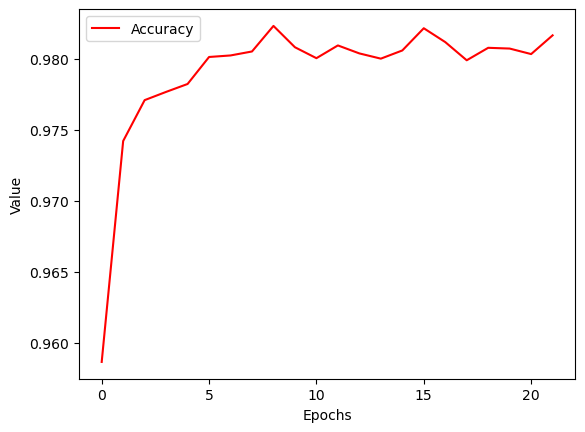

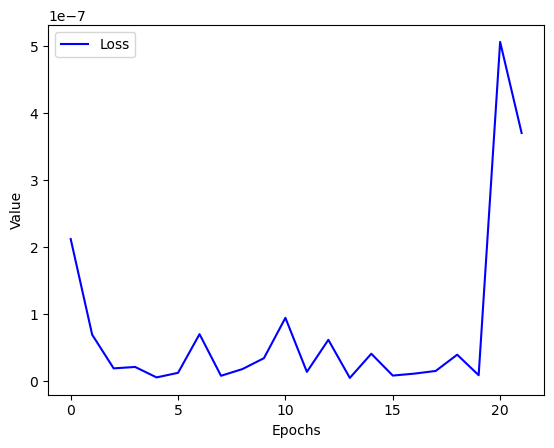

In [27]:
import matplotlib.pyplot as plt

plt.plot(accuracy_list, c="red", label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import accuracy_score
with torch.no_grad():
    acc = []
    wrong = 0
    for sent, tags in mod_test_data:
        words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in sent]
        sentence = torch.tensor(sequence_to_idx(sent, word_map), dtype=torch.long).to(device)

        tag_scores = model(sentence)
        _, indices = torch.max(tag_scores, 1)
        ret = []
        for i in range(len(indices)):
            for key, value in tag_map.items():
                if indices[i] == value:
                    wrong+=1
                    ret.append(key)
        acc.append(accuracy_score(tags, ret))
        # print(accuracy_score(tags, ret))


    print(np.mean(acc))


/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1358702969.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in sent]
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1358702969.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(sent, word_map), dtype=torch.long).to(device)
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1358702969.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch

0.9695857770656106


/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1358702969.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in sent]
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1358702969.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(sent, word_map), dtype=torch.long).to(device)
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_79048/1358702969.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch

In [31]:
wrong

6580

In [32]:
len(mod_test_data)

586

In [48]:
with torch.no_grad():
    wrong = 0
    for sent, tags in mod_train_data:
        words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in sent]
        sentence = torch.tensor(sequence_to_idx(sent, word_map), dtype=torch.long).to(device)

        tagsidx = torch.tensor(tag_to_ix(tags, tag_map), dtype=torch.long).to(device)

        tag_scores = model(sentence, words)
        _, indices = torch.max(tag_scores, 1)
        ret = []
        for i in range(len(indices)):
            if tags[i] != indices[i]:
                wrong+=1
            for key, value in tag_map.items():
                if indices[i] == value:
                    ret.append((sent[i], key))
                    if tags[i] == key:
                        wrong+=1
        print(ret)


/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_70177/49624533.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  words = [torch.tensor(sequence_to_idx(s[0], char_map), dtype=torch.long).to(device) for s in sent]
/var/folders/q5/fcjfcs4s1m78qcydcqd4hn8c0000gn/T/ipykernel_70177/49624533.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(sent, word_map), dtype=torch.long).to(device)


TypeError: unhashable type: 'list'

In [33]:
wrong

1377

In [33]:
a = 0

a = np.sum([ len(i) for i in mod_test_data])

In [34]:
a

1172

In [35]:
torch.save(model, "ptmode.pth")